In [1]:
import numpy as np
import pandas as pd

# viz
import matplotlib.pyplot as plt

# notebook settings
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 1000)

## Sample Prep

In [2]:
samples = pd.read_csv('../data/TCGA/rna-seq_pan/meta/gdc_sample_sheet.2019-12-12.tsv', sep="\t")
# get file type
samples['data'] = [val[1] for i,val in samples['File Name'].str.split(".").items()]
samples['project'] = [val[1] for i,val in samples['Project ID'].str.split("-").items()]
samples['project'].value_counts()

BRCA    1206
LUAD     588
UCEC     567
KIRC     554
LUSC     543
LGG      524
PRAD     517
COAD     506
THCA     505
SKCM     469
BLCA     431
LIHC     421
STAD     402
OV       379
KIRP     308
CESC     306
ESCA     171
PAAD     171
GBM      166
TGCT     150
PCPG     133
LAML     123
KICH      81
ACC       75
CHOL      41
SARC      10
DLBC       9
READ       7
MESO       1
Name: project, dtype: int64

In [3]:
samples['Sample Type'].value_counts()

Primary Tumor                                      8166
Solid Tissue Normal                                 636
Metastatic                                          385
Primary Blood Derived Cancer - Peripheral Blood     123
Recurrent Tumor                                      43
Additional - New Primary                             10
Additional Metastatic                                 1
Name: Sample Type, dtype: int64

## New Model based on Tissues with available metastatic samples

In [4]:
samples[samples['Sample Type']=='Metastatic']['project'].value_counts()
samples[samples['Sample Type']=='Primary Tumor']['project'].value_counts().head(9)

SKCM    364
THCA      7
BRCA      7
CESC      2
PCPG      1
ESCA      1
COAD      1
PAAD      1
PRAD      1
Name: project, dtype: int64

BRCA    1087
UCEC     544
LUAD     528
LGG      506
LUSC     496
KIRC     483
PRAD     466
COAD     465
THCA     445
Name: project, dtype: int64

In [5]:
proj = np.append(samples['project'].value_counts().head(11).index.values, ['SKCM'])

cases = samples[samples['Sample Type']=='Primary Tumor'].sample(frac=1).copy()
cases.shape
cases = cases[cases['project'].isin(proj)]
cases['project'].value_counts()
cases.shape

(8166, 10)

BRCA    1087
UCEC     544
LUAD     528
LGG      506
LUSC     496
KIRC     483
PRAD     466
COAD     465
THCA     445
BLCA     412
SKCM     103
Name: project, dtype: int64

(5535, 10)

## Dataset Prep

In [6]:
from sklearn.model_selection import train_test_split

target = 'project'
cases[target] = cases[target].astype('category')
train, test = train_test_split(cases)

In [7]:
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from trainer import fit
import visualization as vis
import numpy as np

if torch.cuda.is_available():
    cuda = torch.cuda.is_available()
    print("{} GPUs available".format(torch.cuda.device_count()))

classes = train[target].cat.categories.values


8 GPUs available


In [8]:
from tcga_datasets import TCGA, SiameseTCGA
root_dir = "../data/TCGA/rna-seq_pan/"
batch_size = 1

train_dataset = TCGA(root_dir, samples=train, train=True, target=target)
test_dataset = TCGA(root_dir, samples=test, train=False, target=target)
print('Loaded')
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

Loaded


## Siamese Network

In [31]:
# Step 1 set up dataloader
siamese_train_dataset = SiameseTCGA(train_dataset) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseTCGA(test_dataset)
batch_size = 64
kwargs = {'num_workers': 20, 'pin_memory': True} if cuda else {}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from tcga_networks import EmbeddingNet, SiameseNet
from losses import ContrastiveLoss
from metrics import AccumulatedAccuracyMetric

# Step 2
embedding_net = EmbeddingNet()
# Step 3
model = SiameseNet(embedding_net)
if cuda:
    model = nn.DataParallel(model)
    model.cuda()
    
# Step 4
margin = 1.
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 3
# print training metrics every log_interval * batch_size
log_interval = 4

DataParallel(
  (module): SiameseNet(
    (embedding_net): EmbeddingNet(
      (fc): Sequential(
        (0): Linear(in_features=60483, out_features=2000, bias=True)
        (1): PReLU(num_parameters=1)
        (2): Linear(in_features=2000, out_features=500, bias=True)
        (3): PReLU(num_parameters=1)
        (4): Linear(in_features=500, out_features=250, bias=True)
        (5): PReLU(num_parameters=1)
        (6): Linear(in_features=250, out_features=100, bias=True)
        (7): PReLU(num_parameters=1)
        (8): Linear(in_features=100, out_features=50, bias=True)
        (9): PReLU(num_parameters=1)
        (10): Linear(in_features=50, out_features=10, bias=True)
        (11): PReLU(num_parameters=1)
        (12): Linear(in_features=10, out_features=2, bias=True)
      )
    )
  )
)

In [32]:
train_loss, val_loss = fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, 
    n_epochs, cuda, log_interval)

Train: [0/4151 (0%)]	Loss: 0.203820
Train: [256/4151 (6%)]	Loss: 4.784940
Train: [512/4151 (12%)]	Loss: 1.096182
Train: [768/4151 (18%)]	Loss: 0.840253
Train: [1024/4151 (25%)]	Loss: 3.029167
Train: [1280/4151 (31%)]	Loss: 3.232693
Train: [1536/4151 (37%)]	Loss: 0.963296
Train: [1792/4151 (43%)]	Loss: 0.317575
Train: [2048/4151 (49%)]	Loss: 0.191389
Train: [2304/4151 (55%)]	Loss: 0.301726
Train: [2560/4151 (62%)]	Loss: 0.136267
Train: [2816/4151 (68%)]	Loss: 0.158204
Train: [3072/4151 (74%)]	Loss: 0.155527
Train: [3328/4151 (80%)]	Loss: 0.117505
Train: [3584/4151 (86%)]	Loss: 0.109274
Train: [3840/4151 (92%)]	Loss: 0.085358
Train: [3520/4151 (98%)]	Loss: 0.149222
Epoch: 1/3. Train set: Average loss: 0.9674
Epoch: 1/3. Validation set: Average loss: 0.2316
Train: [0/4151 (0%)]	Loss: 0.208626
Train: [256/4151 (6%)]	Loss: 0.164188
Train: [512/4151 (12%)]	Loss: 0.329506
Train: [768/4151 (18%)]	Loss: 0.606267
Train: [1024/4151 (25%)]	Loss: 0.344159
Train: [1280/4151 (31%)]	Loss: 0.162921
Tra

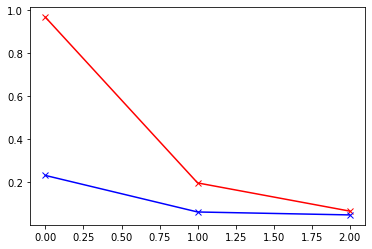

In [33]:
plt.plot(range(0, n_epochs), train_loss, 'rx-')
plt.plot(range(0, n_epochs), val_loss, 'bx-')

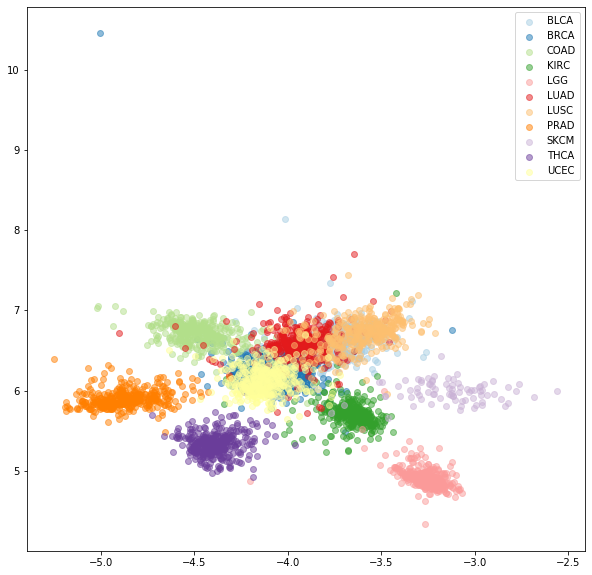

In [34]:
classes = train[target].cat.categories.values
train_embeddings_cl, train_labels_cl = vis.extract_embeddings(train_loader, model)
vis.plot_embeddings(train_embeddings_cl, train_labels_cl, classes)

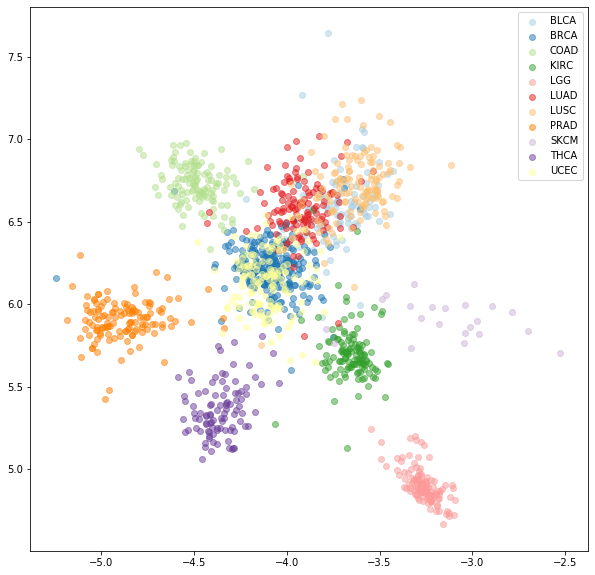

In [35]:
val_embeddings_baseline, val_labels_baseline = vis.extract_embeddings(test_loader, model)
vis.plot_embeddings(val_embeddings_baseline, val_labels_baseline, classes)

### Project Metastatic SKCM onto learned space

In [36]:
skcm_cat = np.where(cases['project'].cat.categories.values=='SKCM')[0][0]

In [37]:
ms = samples[(samples['Sample Type']=='Metastatic') & (samples['project']=='SKCM')].sample(frac=1).copy()
ms[target] = [i + '-MET' for i in ms[target]]
ms[target] = ms[target].astype('category')

met_classes = ms[target].cat.categories.values

In [38]:
root_dir = "../data/TCGA/rna-seq_pan/"
batch_size = 1

ms_dataset = TCGA(root_dir, samples=ms, train=False, target=target)
print('Loaded')
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
ms_loader = torch.utils.data.DataLoader(ms_dataset, batch_size=batch_size, shuffle=False, **kwargs)

Loaded


In [39]:

ms_embeddings_baseline, ms_labels_baseline = vis.extract_embeddings(ms_loader, model)

In [40]:
comb_classes = np.append(classes, met_classes)

comb_embeddings = np.append(train_embeddings_cl, ms_embeddings_baseline, axis=0)
comb_embeddings.shape

ms_labels = np.repeat(np.unique(train_labels_cl).max() + 1, len(ms_labels_baseline))
comb_labels = np.append(train_labels_cl, ms_labels, axis=0)
comb_labels.shape

(4515, 2)

(4515,)

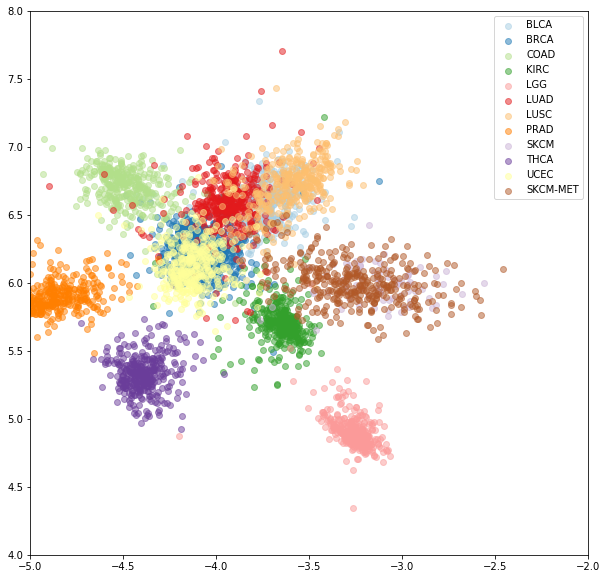

In [42]:
vis.plot_embeddings(comb_embeddings, comb_labels, comb_classes, xlim=(-5,-2), ylim=(4,8))